# IMU

Our Inertial Measurement Unit (IMU) is a combination of accelerometers and gyroscopes in each direction $(x,y,z)$. We can use it to measure how much the rocket accelerates and how fast it rotates. This can also tell us about the speed and altitude of the rocket.


## Acceleration

We start off looking at the vertical component (in body frame) of the measured acceleration during the flight, the accelerometers in the $x$ and $y$ (sideways) direction. The raw accelerometers are quite noisy, passing through a decimation filter helps.

In [11]:
from numpy import loadtxt, array, subtract, divide, multiply, median, std, var, argmax, add, average
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

g_0 = 9.80665

time = []
acc_x = []
acc_y = []
acc_z = []
acc_q = []
with open("../telemetry.csv", 'r') as f_in:
    for line, text in enumerate(f_in.readlines()):
        if line > 1:
            li = text.split(',')
            try:
                a_x = float(li[2])
                a_y = float(li[3])
                a_z = float(li[4])
                a_q = float(li[5])
            except ValueError:
                continue
            time.append(float(li[0]))
            acc_x.append(a_x)
            acc_y.append(a_y)
            acc_z.append(a_z)
            acc_q.append(a_q)

# Jump to the interesting part of the flight
cuttoff = -180000
time = time[cuttoff:]
acc_x = acc_x[cuttoff:]
acc_y = acc_y[cuttoff:]
acc_z = acc_z[cuttoff:]

# Find the moment of liftoff, set MET=0
liftoff = time[8000+argmax(acc_z[8000:9000])]
with open("launch-time.csv", 'w') as out:
    out.write("%f\n"%liftoff)
time = subtract(time, liftoff)

# decimation filter, also to get time resoultion
last_t = time[0]
last_break = 0
acc_x_decimated = []
acc_y_decimated = []
acc_z_decimated = []
acc_q_decimated = []
time_decimated = []
for i, t in enumerate(time):
    if t != last_t:
        acc_x_decimated.append(average(acc_x[last_break:i]))
        acc_y_decimated.append(average(acc_y[last_break:i]))
        acc_z_decimated.append(average(acc_z[last_break:i]))
        acc_q_decimated.append(average(acc_q[last_break:i]))
        time_decimated.append(t)
        last_break = i;
    last_t = t
    
acc_z_unfiltered = acc_z

# Used esitmated gains and bias from http://psas.pdx.edu/DataAnalysis/
acc_x = divide(subtract(acc_x_decimated, 2400.45), 392.80)
acc_y = divide(subtract(acc_y_decimated, 2462.06), 386.90)
z_zero = median(acc_z[:300])
acc_z = divide(subtract(acc_z_decimated, z_zero),  -76.10)
acc_z_unfiltered = divide(subtract(acc_z_unfiltered, z_zero),  -76.10)
acc_q = divide(subtract(acc_q_decimated, 1907.53),  -75.40)

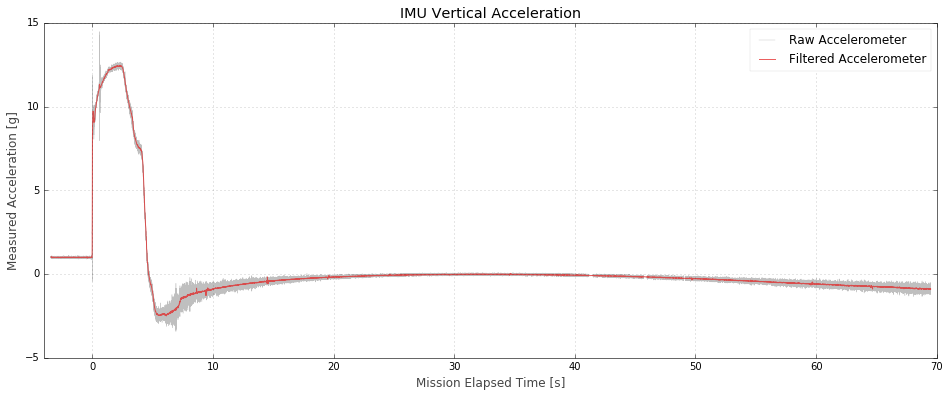

In [2]:
fig, ax1 = plt.subplots(figsize=(16,6))
plt.title(r"IMU Vertical Acceleration")
plt.ylabel(r"Measured Acceleration [g]")
plt.xlabel(r"Mission Elapsed Time [s]")
plt.plot(time, add(acc_z_unfiltered, 1.0), 'k-', alpha=0.25, lw=0.4, label="Raw Accelerometer")
plt.plot(time_decimated, add(acc_z, 1.0), alpha=0.7, lw=1.0, label="Filtered Accelerometer")
plt.xlim([-4,70])
ax1.legend(loc=1)
plt.show()

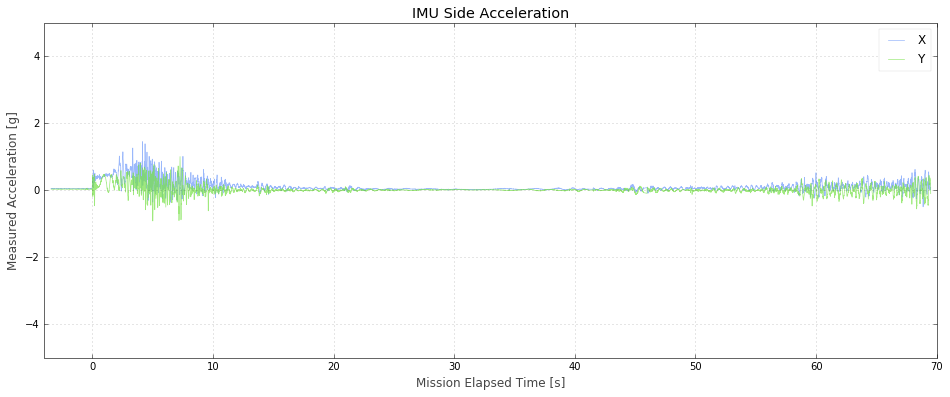

In [3]:
fig, ax1 = plt.subplots(figsize=(16,6))
plt.title(r"IMU Side Acceleration")
plt.ylabel(r"Measured Acceleration [g]")
plt.xlabel(r"Mission Elapsed Time [s]")
plt.plot([-300,-301], [9,9])
plt.plot(time_decimated, acc_x, alpha=0.7, lw=0.7, label="X")
plt.plot(time_decimated, acc_y, alpha=0.7, lw=0.7, label="Y")
plt.xlim([-4,70])
plt.ylim([-5,5])
ax1.legend(loc=1)
plt.show()

## Velocity

A single integration of the vertical acceleration will give approximate velocity. There will be some drift as the tiny errors in the IMU readings slowly add up over the integration.

In [4]:
from scipy.integrate import simps

acc_ms = multiply(acc_z, g_0)
velocity = [0]
for i in range(len(acc_x)):
    if(i > 0):
        velocity.append(simps(acc_ms[:i], time_decimated[:i]))

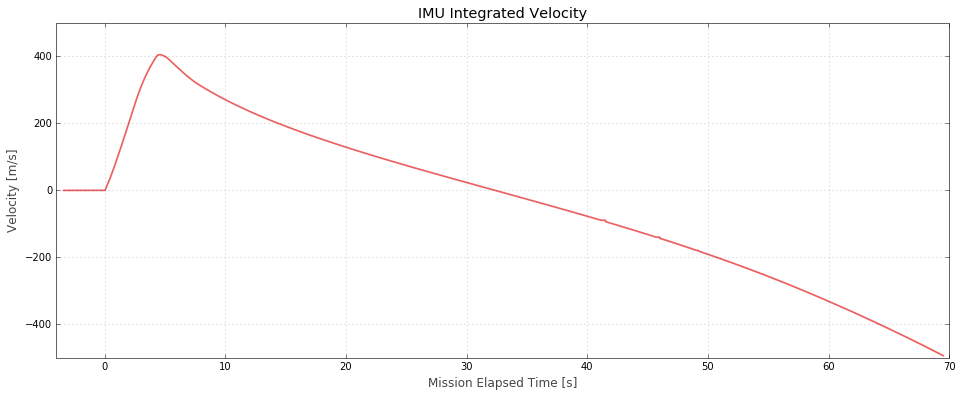

In [5]:
fig, ax1 = plt.subplots(figsize=(16,6))
plt.title(r"IMU Integrated Velocity")
plt.ylabel(r"Velocity [m/s]")
plt.xlabel(r"Mission Elapsed Time [s]")
plt.plot(time_decimated, velocity, alpha=0.7, label="Integrated Velocity")
plt.xlim([-4,70])
#plt.ylim([-4,4])
#ax1.legend(loc=1)
plt.show()

In [6]:
vpeak = max(velocity)
print "The peak velocity during the motor burn was %0.0f m/s (Mach %0.1f)." % (vpeak, vpeak/330.0)

The peak velocity during the motor burn was 406 m/s (Mach 1.2).


## Altitude

Further integrating the velocity numbers should get us altitude. Here we really see the IMU drift. After 70 seconds our guess of altitude is almost 2 kilometers off! (the rocket landed on the ground, not 2000 meters underground).

Hopfully we can fix this with filters that take into acconut several sensors, like pressure and GPS fixes, in order to de-bias our IMU drift.

In [7]:
alt = [0]
for i in range(len(velocity)):
    if(i > 0):
        alt.append(simps(velocity[:i], time_decimated[:i]))

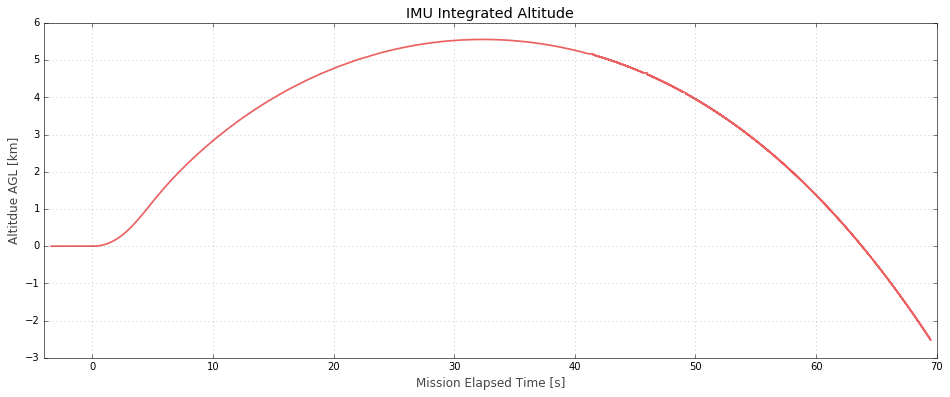

In [8]:
fig, ax1 = plt.subplots(figsize=(16,6))
plt.title(r"IMU Integrated Altitude")
plt.ylabel(r"Altitdue AGL [km]")
plt.xlabel(r"Mission Elapsed Time [s]")
plt.plot(time_decimated, divide(alt, 1000.0), alpha=0.7, label="Integrated Altitude")
plt.xlim([-4,70])
#plt.ylim([-4,4])
#ax1.legend(loc=1)
plt.show()

In [9]:
import locale
locale.setlocale(locale.LC_ALL, '')

altpeak = max(alt)
print "According to the IMU the apogee was %0.2f kilometers. And then we \"landed\" %s meters underground" % (altpeak/1000.0, locale.format("%0.0f", -alt[-1], grouping=True))

According to the IMU the apogee was 5.56 kilometers. And then we "landed" 2,525 meters underground


In [10]:
# Write intermediate results for future use
with open('uncalibrated_integrated_velocity.csv', 'w') as fout:
    for i, t in enumerate(time_decimated):
        fout.write(",".join(["%0.12f"%t, "%0.3f"%velocity[i]]))
        fout.write("\n")

with open('uncalibrated_integrated_altitude.csv', 'w') as fout:
    for i, t in enumerate(time_decimated):
        fout.write(",".join(["%0.12f"%t, "%0.3f"%alt[i]]))
        fout.write("\n")